### Configs

In [1]:
colab = 1

lr_OD = 0.005
lr_DD = 0.01

convert2png = 0


# class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
#                'bus', 'train', 'truck', 'boat', 'traffic light',
#                'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
#                'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
#                'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
#                'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
#                'kite', 'baseball bat', 'baseball glove', 'skateboard',
#                'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
#                'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
#                'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
#                'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
#                'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
#                'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
#                'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
#                'teddy bear', 'hair drier', 'toothbrush']

               
num_classes = 894

num_epochs = 50

load_model = 1
save_model = 1

path2dataset = "nyu_depth_v2_labeled.mat"

if colab==0:
    root_folder = "Datas"
    OD_model_save_dir = "Models/ODModel.pth.tar"
    DD_model_save_dir = "Models/DDModel.pth.tar"

    OD_logs_path = "Logs/ODLogs.txt"
    DD_logs_path = "Logs/DDLogs.txt"
    
else:
    root_folder = "/content/drive/My Drive/Courses/DeepLearning/Project/Datas"
    
    OD_model_save_dir = "/content/drive/My Drive/Courses/DeepLearning/Project/Models/ODModel.pth.tar"    
    DD_model_save_dir = "/content/drive/My Drive/Courses/DeepLearning/Project/Models/DDModel.pth.tar"

    OD_logs_path = "/content/drive/My Drive/Courses/DeepLearning/Project/Logs/ODLogs.txt"
    DD_logs_path = "/content/drive/My Drive/Courses/DeepLearning/Project/Logs/DDLogs.txt"

### Imports

In [2]:
if colab:
    !pip install mat73
    !pip install timm
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.append("/content/drive/My Drive/Courses/DeepLearning/Project")

## Python Files

import utils
import datas
import models
from engine import train_one_epoch_OD, train_one_epoch_DD, evaluate
import transforms as T

## Libraries
import os  # when loading file paths
import numpy as np
from PIL import Image  # Load img
import torch
import torch.nn as nn
import statistics
import torchvision
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import mat73
import cv2 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Setting up GPU Device

In [3]:
# Setting device on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cpu



### Convert .mat to .png images for memory managment during training

In [4]:
if convert2png:
    utils.mat2png(path2dataset)

### Load datas

In [5]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


transform = get_transform(train=True)

train_loader, test_loader = datas.get_loader(root_folder, batch_size=4, num_datas=1449, train_test_ratio=0.9, transform=transform)

In [6]:
images, depths, targets = next(iter(train_loader))

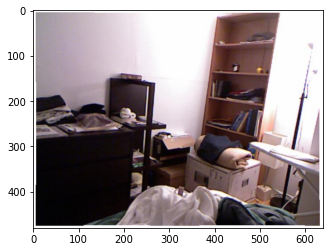

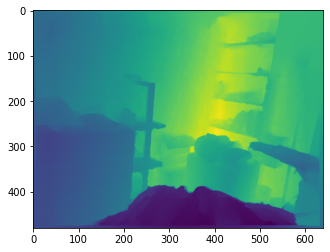

In [7]:
plt.imshow(images[2].permute(1,2,0).cpu().numpy())
plt.figure()
plt.imshow(depths[2].permute(1,2,0).cpu().numpy())

### Training  - Object Detector

In [13]:
object_detector = models.ObjectDetector(num_classes=num_classes).to(device)
criterion = nn.MSELoss().to(device)
params = [p for p in object_detector.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr_OD,
                            momentum=0.9, weight_decay=0.0005)

In [28]:
if load_model:
      utils.load_checkpoint(torch.load(OD_model_save_dir, map_location=torch.device(device)), object_detector, optimizer)

for epoch in range(num_epochs):
    logs = train_one_epoch_OD(object_detector, optimizer, train_loader, device, epoch, print_freq=5, logs_path=OD_logs_path)
    evaluate(object_detector, test_loader, device=device)
    if save_model:
        checkpoint = {
            "state_dict": object_detector.state_dict(),
            "optimizer": optimizer.state_dict(),
            }
        utils.save_checkpoint(checkpoint, filename=OD_model_save_dir)

=> Loading checkpoint


/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


KeyboardInterrupt: ignored

In [ ]:
# pick one image from the test set
images, depths, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
img = images[3]
# put the model in evaluation mode
object_detector.eval()
with torch.no_grad():
    prediction = object_detector([img.to(device)])
    
plt.imshow(img.permute(1,2,0).cpu().numpy())

[{'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([]),
  'masks': tensor([], size=(0, 1, 480, 640))}]

In [ ]:
plot_img = 0
for obj in range(15):
  plot_img = plot_img + prediction[0]['masks'][obj, 0].mul(255)
plt.imshow(plot_img.cpu().numpy())

### Training - Depth Estimation

In [14]:
model_type = "DPT_Hybrid"
depth_estimator = models.DepthEstimation(model_type)

depth_estimator.to(device)
criterion = nn.MSELoss().to(device)
params = [p for p in depth_estimator.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr_DD,
                            momentum=0.9, weight_decay=0.0005)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [12]:
if load_model:
      utils.load_checkpoint(torch.load(DD_model_save_dir, map_location=torch.device(device)), depth_estimator, optimizer)

for epoch in range(num_epochs):
  # train_one_epoch_DD(depth_estimator, optimizer, criterion, train_loader, device, epoch, print_freq=20, logs_path=DD_logs_path)

  if save_model:
        checkpoint = {
            "state_dict": depth_estimator.state_dict(),
            "optimizer": optimizer.state_dict(),
            }
        utils.save_checkpoint(checkpoint, filename=DD_model_save_dir)

RuntimeError: ignored

### Joint Depth Estimation and Object Detection

In [9]:
if load_model:
      object_detector = models.ObjectDetector(num_classes=num_classes).to(device)
      criterion = nn.MSELoss().to(device)
      params = [p for p in object_detector.parameters() if p.requires_grad]
      optimizer = torch.optim.SGD(params, lr=lr_OD,
                                  momentum=0.9, weight_decay=0.0005)
      utils.load_checkpoint(torch.load(OD_model_save_dir, map_location=torch.device(device)), object_detector, optimizer)
      model_type = "DPT_Hybrid"
      depth_estimator = models.DepthEstimation(model_type)
      depth_estimator.to(device)

=> Loading checkpoint


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


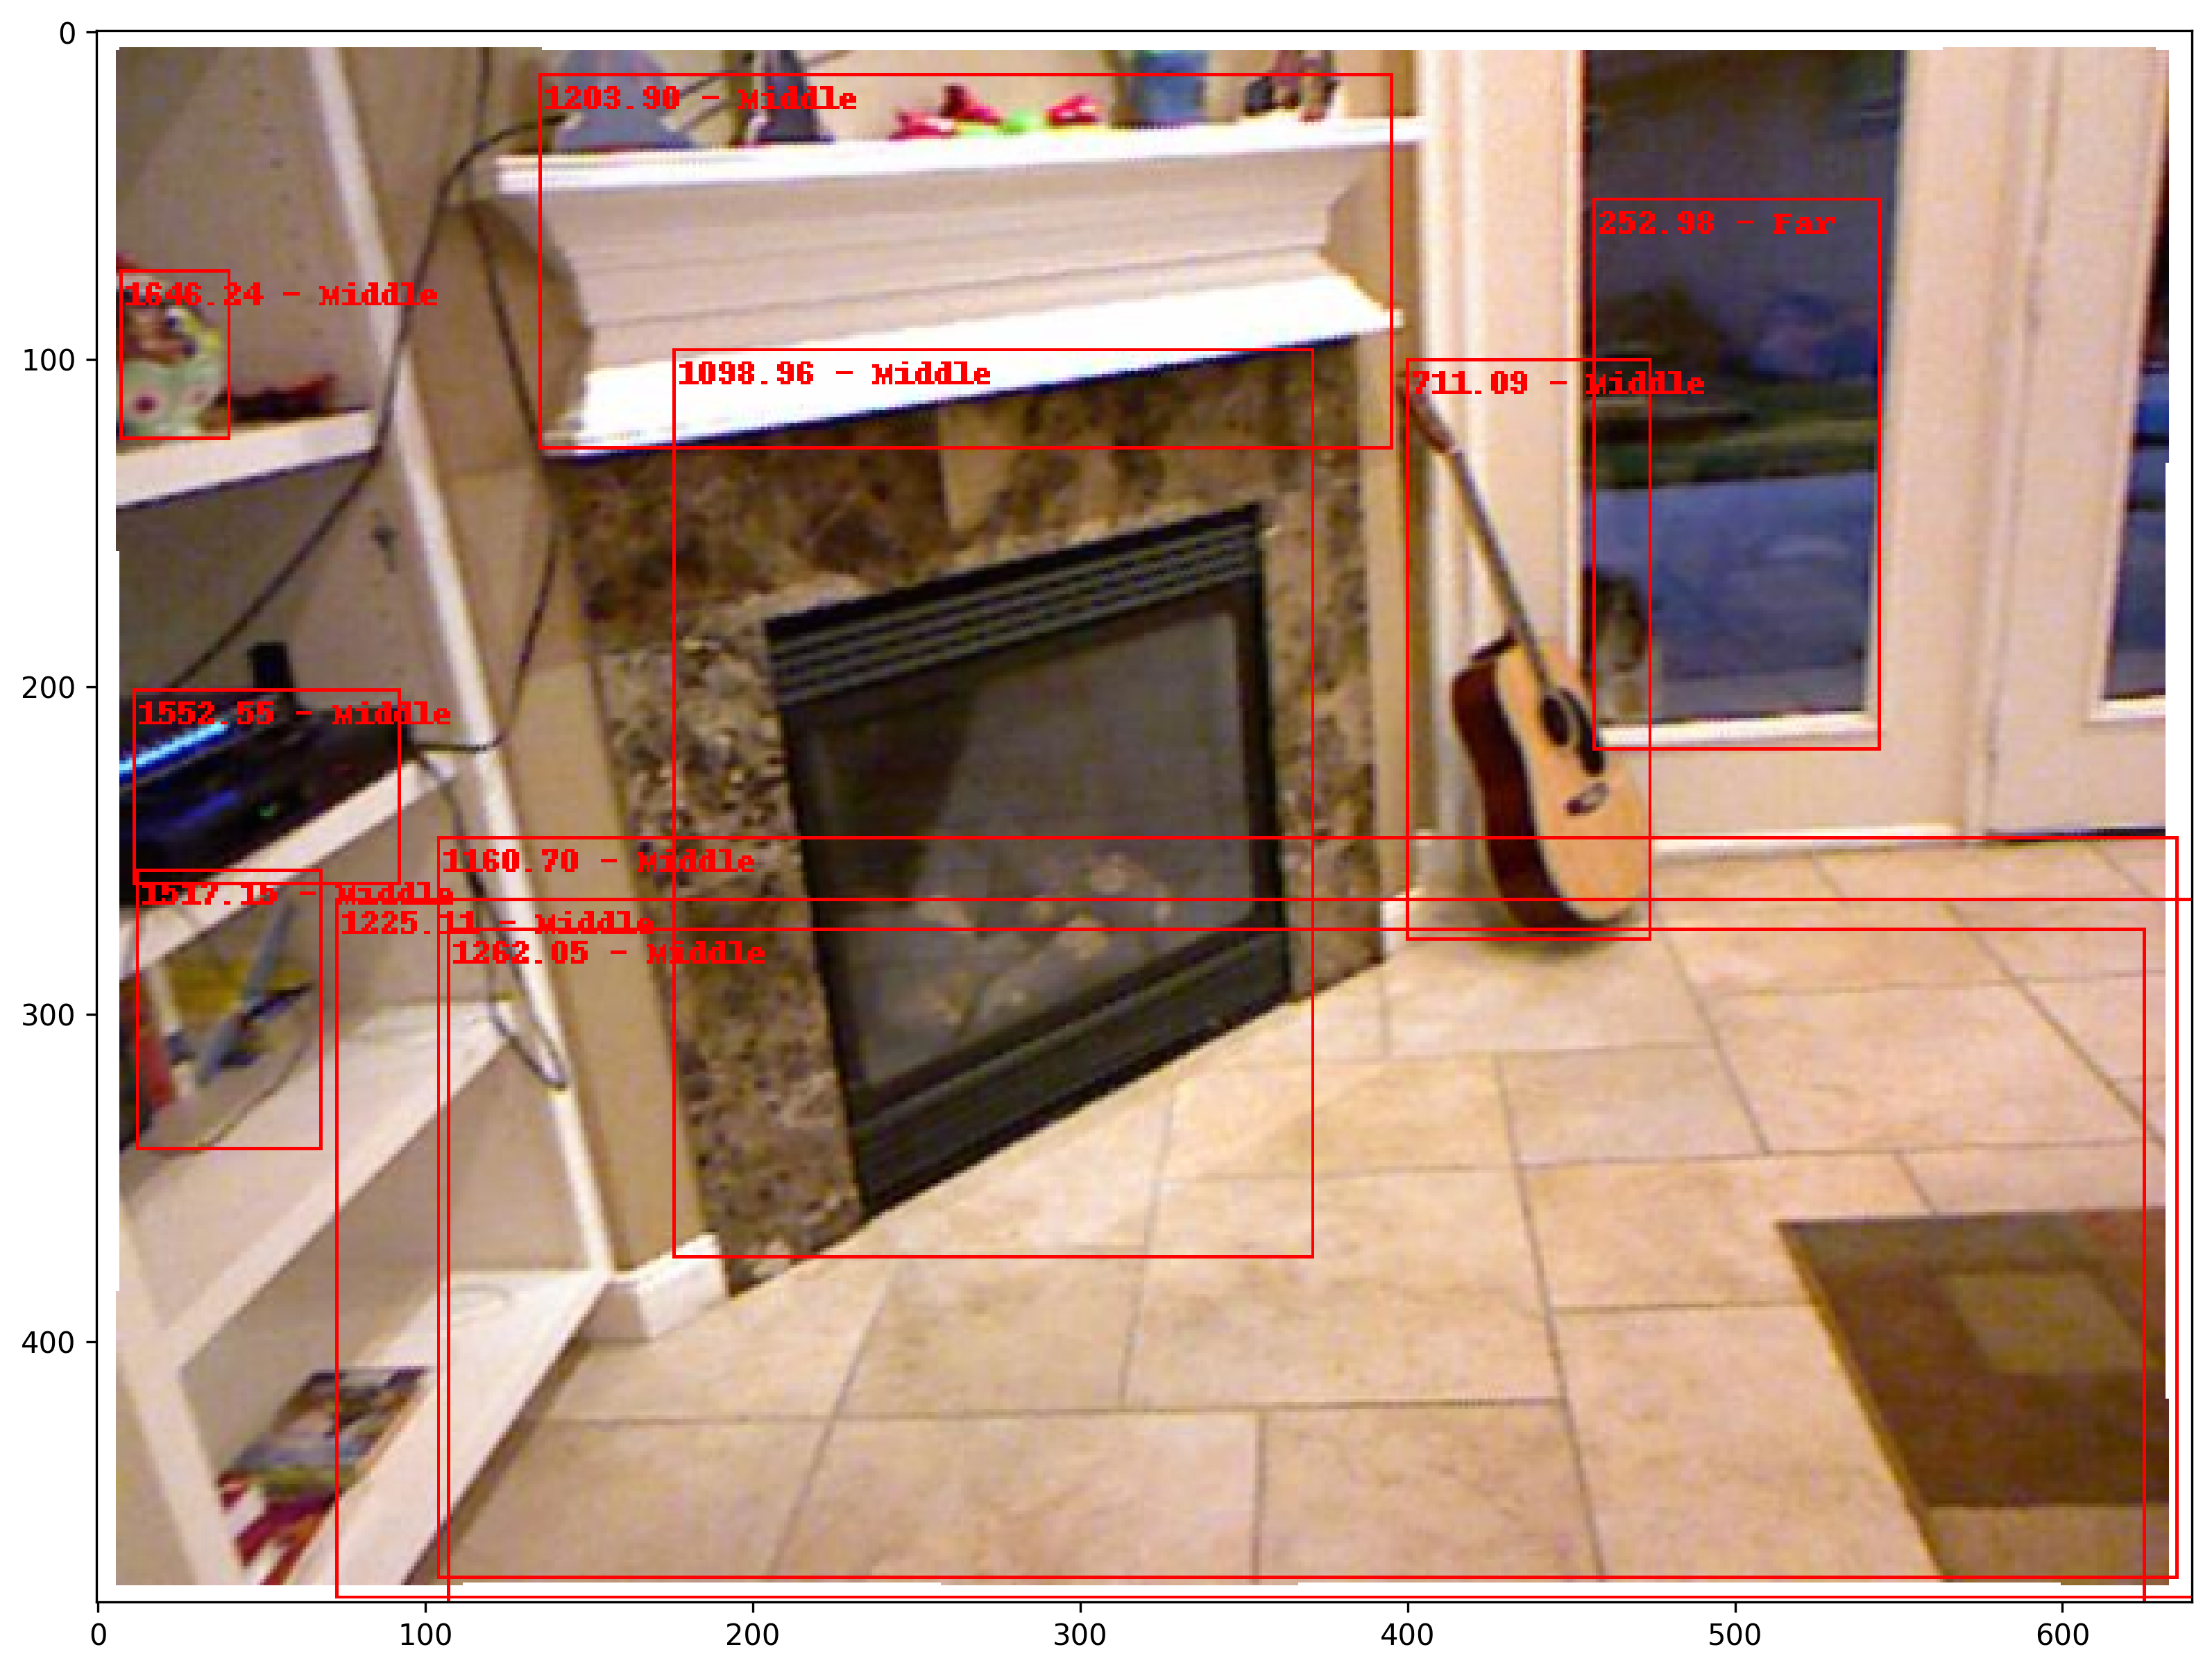

In [10]:
concater = models.Concater(object_detector, depth_estimator)

images = list(image for image in images)
img = images[3].to(device)

plot_img = concater.out(img)

fig = plt.figure()
fig.set_size_inches(18, 10)
fig.set_dpi(300)
plt.imshow(plot_img)
plt.show()